In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

max_images = 200
batch_size = 2048
learning_rate = .002
num_epochs = 25

In [3]:
#GET TARGET DATA

def get_cod(file):
    data = np.load(file)
    bands = data['rad'].reshape(128 * 128, 16)
    cod = data['l2_cod'].flatten().reshape(-1, 1)/1000
    return bands, cod

In [4]:
#CREATE DATASET

file_list = glob.glob('../ABI_Data/*.npz')

X = []
y = []

for i, file in enumerate(file_list):
    features, target = get_cod(file)
    X.append(features)
    y.append(target)
    if i == max_images: break

X = torch.from_numpy(np.concatenate(X, axis=0))
y = torch.from_numpy(np.concatenate(y, axis=0))

dataset = TensorDataset(X, y)

In [5]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
#CREATE MODEL

class FeedForwardRegressor(nn.Module):
    def __init__(self, input_dim=16, output_dim=1):
        super(FeedForwardRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

model = FeedForwardRegressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [7]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader):
    model.train()
    train_loss = 0
    total = 0
    all_preds, all_labels = [], []

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.float().to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        total += labels.size(0)

        all_preds.append(outputs.detach().cpu())
        all_labels.append(labels.detach().cpu())

    train_loss /= total
    r2 = r2_score(torch.cat(all_labels).numpy(), torch.cat(all_preds).numpy())
    return train_loss, r2


def eval(model, val_loader):
    model.eval()
    val_loss = 0
    total = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            total += labels.size(0)

            all_preds.append(outputs.cpu())
            all_labels.append(labels.cpu())

    val_loss /= total
    r2 = r2_score(torch.cat(all_labels).numpy(), torch.cat(all_preds).numpy())
    return val_loss, r2

In [8]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = eval(model, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch: {e} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

100%|██████████| 1287/1287 [00:18<00:00, 68.52it/s] 


Epoch: 1 | Train Loss: 39.9042 | Train Acc: 0.1318 | Val Loss: 38.2533 | Val Acc: 0.1890


100%|██████████| 1287/1287 [00:15<00:00, 80.52it/s]


Epoch: 2 | Train Loss: 36.2746 | Train Acc: 0.2108 | Val Loss: 36.4352 | Val Acc: 0.2276


100%|██████████| 1287/1287 [00:15<00:00, 81.98it/s]


Epoch: 3 | Train Loss: 35.4223 | Train Acc: 0.2293 | Val Loss: 38.0917 | Val Acc: 0.1924


100%|██████████| 1287/1287 [00:15<00:00, 83.52it/s] 


Epoch: 4 | Train Loss: 33.7230 | Train Acc: 0.2663 | Val Loss: 32.9784 | Val Acc: 0.3008


100%|██████████| 1287/1287 [00:15<00:00, 82.83it/s] 


Epoch: 5 | Train Loss: 31.6701 | Train Acc: 0.3110 | Val Loss: 31.0958 | Val Acc: 0.3407


100%|██████████| 1287/1287 [00:15<00:00, 81.57it/s]


Epoch: 6 | Train Loss: 30.4127 | Train Acc: 0.3383 | Val Loss: 30.5650 | Val Acc: 0.3520


100%|██████████| 1287/1287 [00:15<00:00, 82.43it/s]


Epoch: 7 | Train Loss: 29.3597 | Train Acc: 0.3612 | Val Loss: 29.5266 | Val Acc: 0.3740


100%|██████████| 1287/1287 [00:15<00:00, 85.11it/s] 


Epoch: 8 | Train Loss: 28.6529 | Train Acc: 0.3766 | Val Loss: 31.3569 | Val Acc: 0.3352


100%|██████████| 1287/1287 [00:15<00:00, 84.52it/s] 


Epoch: 9 | Train Loss: 28.3560 | Train Acc: 0.3831 | Val Loss: 28.2035 | Val Acc: 0.4021


100%|██████████| 1287/1287 [00:15<00:00, 84.61it/s] 


Epoch: 10 | Train Loss: 27.4797 | Train Acc: 0.4021 | Val Loss: 28.1541 | Val Acc: 0.4031


100%|██████████| 1287/1287 [00:15<00:00, 84.16it/s] 


Epoch: 11 | Train Loss: 27.3419 | Train Acc: 0.4051 | Val Loss: 28.1243 | Val Acc: 0.4037


100%|██████████| 1287/1287 [00:15<00:00, 82.91it/s] 


Epoch: 12 | Train Loss: 26.7490 | Train Acc: 0.4180 | Val Loss: 26.4047 | Val Acc: 0.4402


100%|██████████| 1287/1287 [00:15<00:00, 83.26it/s] 


Epoch: 13 | Train Loss: 26.4373 | Train Acc: 0.4248 | Val Loss: 28.2998 | Val Acc: 0.4000


100%|██████████| 1287/1287 [00:15<00:00, 82.85it/s] 


Epoch: 14 | Train Loss: 25.8024 | Train Acc: 0.4386 | Val Loss: 25.5738 | Val Acc: 0.4578


100%|██████████| 1287/1287 [00:15<00:00, 81.95it/s]


Epoch: 15 | Train Loss: 25.8366 | Train Acc: 0.4379 | Val Loss: 28.3985 | Val Acc: 0.3979


100%|██████████| 1287/1287 [00:15<00:00, 82.55it/s]


Epoch: 16 | Train Loss: 25.3785 | Train Acc: 0.4479 | Val Loss: 24.1571 | Val Acc: 0.4879


100%|██████████| 1287/1287 [00:15<00:00, 82.53it/s]


Epoch: 17 | Train Loss: 25.7334 | Train Acc: 0.4401 | Val Loss: 27.5357 | Val Acc: 0.4162


100%|██████████| 1287/1287 [00:15<00:00, 81.50it/s]


Epoch: 18 | Train Loss: 26.2370 | Train Acc: 0.4292 | Val Loss: 28.2042 | Val Acc: 0.4021


100%|██████████| 1287/1287 [00:15<00:00, 81.32it/s]


Epoch: 19 | Train Loss: 25.7684 | Train Acc: 0.4394 | Val Loss: 29.0086 | Val Acc: 0.3850


100%|██████████| 1287/1287 [00:15<00:00, 81.33it/s]


Epoch: 20 | Train Loss: 25.3962 | Train Acc: 0.4475 | Val Loss: 24.2656 | Val Acc: 0.4856


100%|██████████| 1287/1287 [00:15<00:00, 81.29it/s]


Epoch: 21 | Train Loss: 25.4589 | Train Acc: 0.4461 | Val Loss: 27.1158 | Val Acc: 0.4251


100%|██████████| 1287/1287 [00:15<00:00, 82.31it/s]


Epoch: 22 | Train Loss: 24.9309 | Train Acc: 0.4576 | Val Loss: 29.5012 | Val Acc: 0.3746


100%|██████████| 1287/1287 [00:15<00:00, 81.57it/s]


Epoch: 23 | Train Loss: 24.9092 | Train Acc: 0.4581 | Val Loss: 23.7700 | Val Acc: 0.4961


100%|██████████| 1287/1287 [00:15<00:00, 82.17it/s]


Epoch: 24 | Train Loss: 24.7159 | Train Acc: 0.4623 | Val Loss: 24.1573 | Val Acc: 0.4878


100%|██████████| 1287/1287 [00:15<00:00, 82.16it/s]


Epoch: 25 | Train Loss: 24.5038 | Train Acc: 0.4669 | Val Loss: 27.8277 | Val Acc: 0.4100


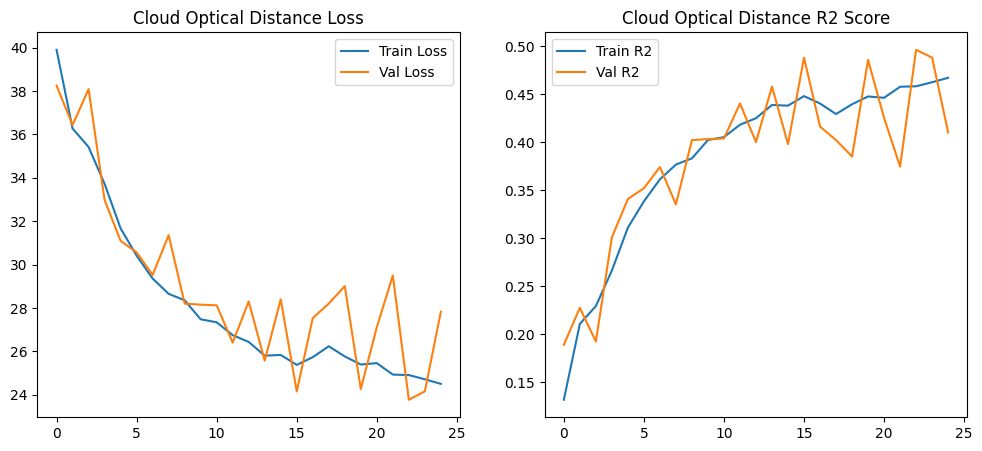

In [9]:
#PLOT LOSS and ACCURACY

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Cloud Optical Distance Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train R2')
plt.plot(val_accuracies, label='Val R2')
plt.title('Cloud Optical Distance R2 Score')
plt.legend()

plt.savefig("./graphs/mlp_cod.png")  

plt.show()

In [10]:
#MODEL EVALUATION

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        outputs = model(inputs)
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))


100%|██████████| 161/161 [00:01<00:00, 95.27it/s] 


r2: 0.4058168129740076
MSE: 27.507820909631878
